In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# importing the data into arrays
# first column of the data file is phase data
LTPhaseHalf = np.loadtxt("GD356LT.dat", usecols=(0))
LTPhase = np.concatenate((LTPhaseHalf, LTPhaseHalf+1))
# second column of the data file is flux data
LTFluxHalf = np.loadtxt("GD356LT.dat", usecols=(1))
LTFlux = np.concatenate((LTFluxHalf+1, LTFluxHalf+1))
# third column of the data file is flux error
LTErrorHalf = np.loadtxt("GD356LT.dat", usecols=(2))
LTError = np.concatenate((LTErrorHalf, LTErrorHalf))

In [4]:
def mean_data(Phase, Flux, Error, bins):

    Phase_split = np.array_split(Phase, bins)
    Flux_split = np.array_split(Flux, bins)
    Error_split = np.array_split(Error, bins)

    meanPhase = [] * bins
    meanFlux = [] * bins
    meanError = [] * bins

    for i in range(bins):

        meanPhase_i = np.mean(Phase_split[i])
        meanFlux_i = np.sum(Flux_split[i] / (Error_split[i]**2))/ np.sum(1/(Error_split[i]**2))

        meanError_i = np.sqrt(1/np.sum(1/(Error_split[i]**2)))

        meanPhase.append(meanPhase_i)
        meanFlux.append(meanFlux_i)
        meanError.append(meanError_i)
        
    return meanPhase, meanFlux, meanError

meanPhase, meanFlux, meanError = mean_data(LTPhase, LTFlux, LTError, 200)

In [5]:
import numpy as np
import starry
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import matplotlib.pyplot as plt
import theano.tensor as tt

starry.config.lazy = True
starry.config.quiet = True

In [6]:
flux = meanFlux
flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

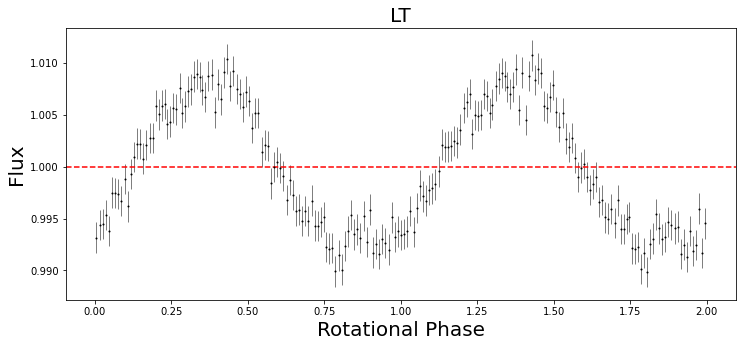

In [7]:
plt.figure(figsize=(12, 5))

plt.title('LT', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [8]:
amplitude = (np.amax(flux) - np.amin(flux))/2
flux_err/amplitude

0.13969228656288163

# Medium Radius

In [12]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=0.08, testval=0.06)
    radius = pm.Uniform("radius", lower=20.0, upper=60.0, testval=40.0)
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [13]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, radius, contrast]


message: Optimization terminated successfully.
logp: -545.1564450600076 -> 992.9412291022772


In [14]:
keys = ["contrast", "radius", "lat", "lon", "inc"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.07568
radius       57.90863
lat          76.70192
lon          48.99557
inc          57.36413


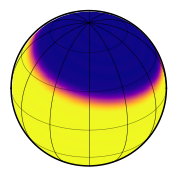

In [15]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.07568, radius=57.90863, lat=76.70192, lon=48.99557)
map.inc = 57.36413
map.show()

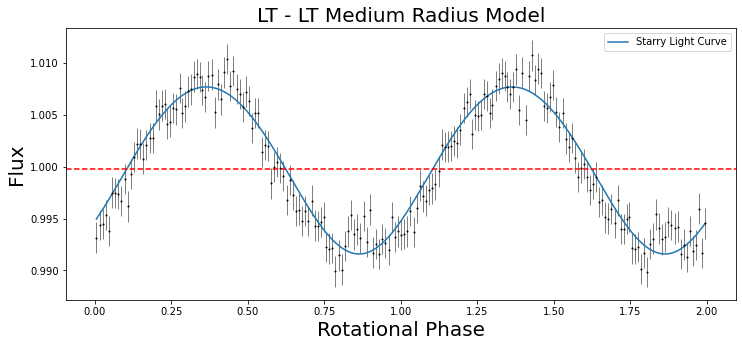

In [16]:
newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('LT - LT Medium Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [17]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

1.2209904387103774

# Large Radius

In [18]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=0.08, testval=0.06)
    radius = pm.Uniform("radius", lower=60.0, upper=90.0, testval=80.0)
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [19]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, radius, contrast]


message: Optimization terminated successfully.
logp: -537.8146769940914 -> 1000.6569173334586


In [20]:
keys = ["contrast", "radius", "lat", "lon", "inc"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.07607
radius       61.29632
lat          68.17059
lon          48.96626
inc          21.67550


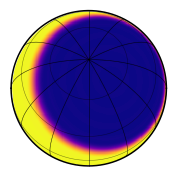

In [21]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.07607, radius=61.29632, lat=68.17059, lon=48.96626)
map.inc = 21.67550
map.show()

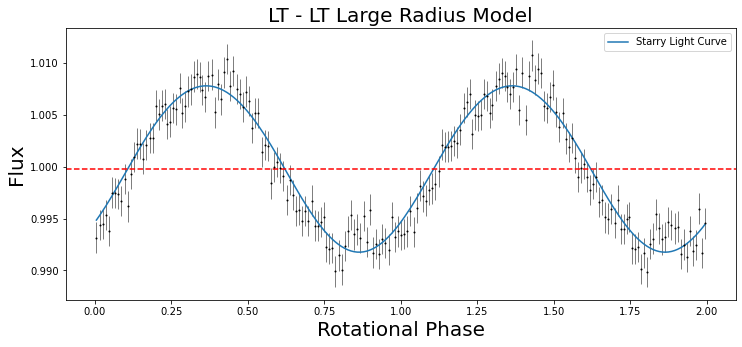

In [22]:
newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('LT - LT Large Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [23]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

1.1410835018289243

In [11]:
amplitude = (np.amax(newFlux) - np.amin(newFlux)) / 2
amplitude

0.008025233499686035

# TESS - Medium Radius

In [18]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 20.52788
    lat = 47.71131
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 41.76645
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [19]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Desired error not necessarily achieved due to precision loss.
logp: -36628.503857792966 -> 1011.2311057814815


In [20]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.15681
lon          49.06276


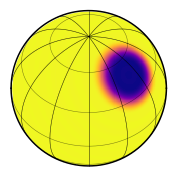

In [6]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.15681, radius=20.52788, lat=47.71131, lon=49.06276)
map.inc = 41.76645
map.show()

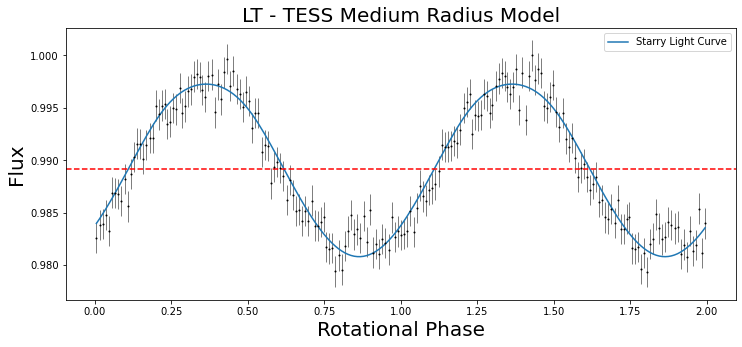

In [7]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('LT - TESS Medium Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [9]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

1.1086467564806468

# TESS - Large Radius

In [10]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 89.64379
    lat = -44.26156
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 24.04429
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [11]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -403601.8029184171 -> 1009.8289120090503


In [12]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.05923
lon          48.82313


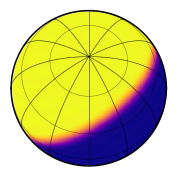

In [13]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.05923, radius=89.64379, lat=-44.26156, lon=48.82313)
map.inc = 24.04429
map.show()

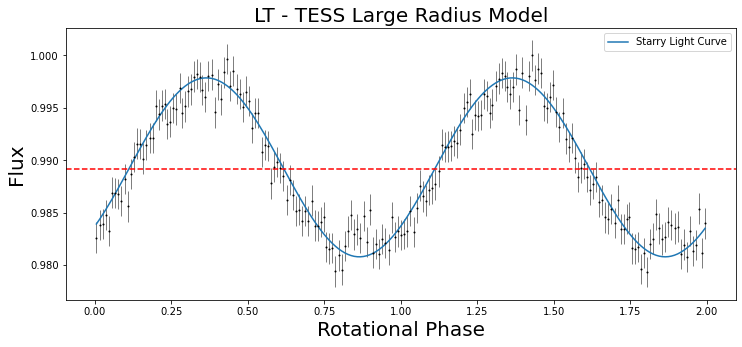

In [14]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('LT - TESS Large Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [16]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

1.1140542091333607

In [14]:
amplitude = (np.amax(newFlux) - np.amin(newFlux)) / 2
amplitude

0.008532627033299933

# PTO - Small Radius

In [17]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 13.11429
    lat = 44.35413
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 37.85545
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [18]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -1233.5908330140467 -> 1014.3334672572712


In [19]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.37571
lon          48.91512


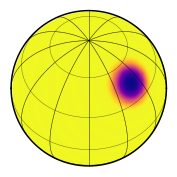

In [20]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.37556, radius=13.11429, lat=44.35413, lon=48.91512)
map.inc = 37.85545
map.show()

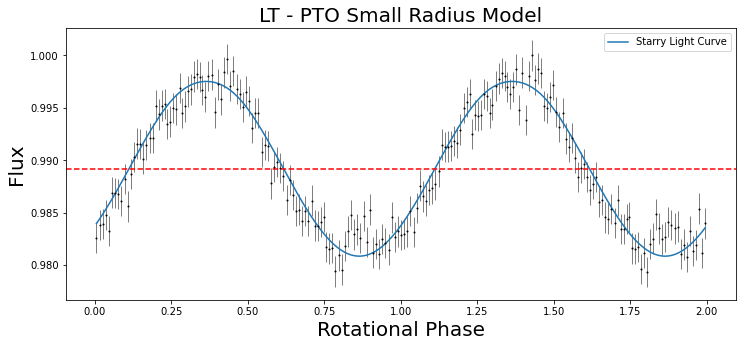

In [21]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('LT - PTO Small Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [24]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

1.0828470783290918

In [17]:
amplitude = (np.amax(newFlux) - np.amin(newFlux)) / 2
amplitude

0.008336145267039352

# PTO - Medium radius

In [25]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 23.28693
    lat = 46.48269
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 40.46170
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [26]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -70045.4629697173 -> 1010.9879964331263


In [27]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.12322
lon          49.10639


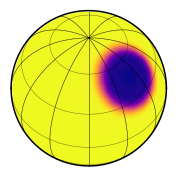

In [28]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.12322, radius=23.28693, lat=46.48269, lon=49.10639)
map.inc = 40.46170
map.show()

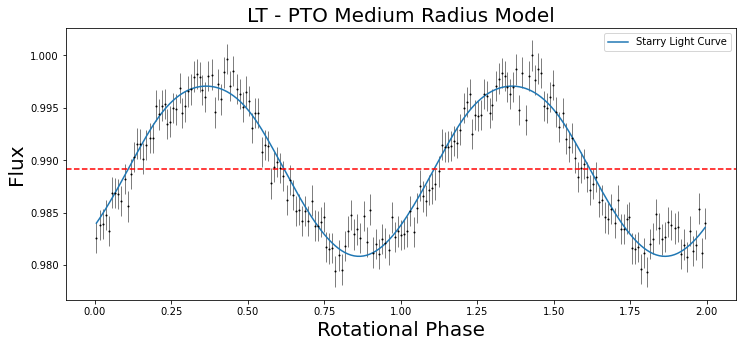

In [29]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('LT - PTO Medium Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [31]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

1.1108783394810133

# PTO - Large Radius

In [32]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 87.13632
    lat = -42.35981
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 22.28141
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [33]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -337736.18238667626 -> 1010.4887221719799


In [34]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.06408
lon          48.88451


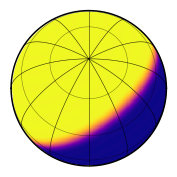

In [35]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.06408, radius=87.13632, lat=-42.35981, lon=48.88451)
map.inc = 22.28141
map.show()

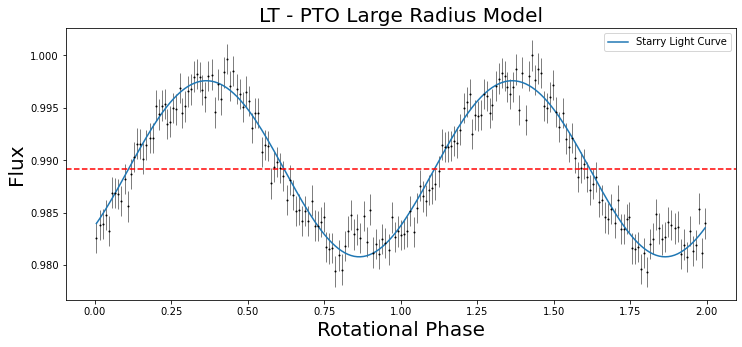

In [36]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('LT - PTO Large Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [38]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

1.108344103363413

In [20]:
amplitude = (np.amax(newFlux) - np.amin(newFlux)) / 2
amplitude

0.008397372626947841

# WHT - Small Radius

In [39]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 15.39599
    lat = 50.73618
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 34.22757
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [40]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Desired error not necessarily achieved due to precision loss.
logp: -7540.116136938484 -> 935.5995154249691


In [41]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.25222
lon          48.99607


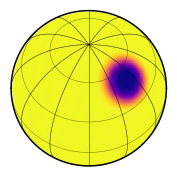

In [42]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.25222, radius=15.39599, lat=50.73618, lon=48.99607)
map.inc = 34.22757
map.show()

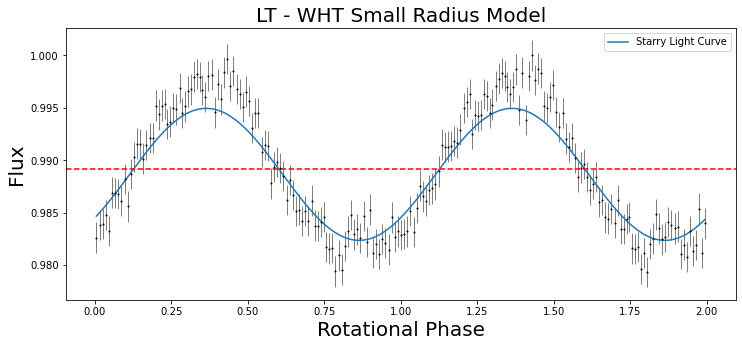

In [43]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('LT - WHT Small Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [45]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

1.931214836368086

In [23]:
amplitude = (np.amax(newFlux) - np.amin(newFlux)) / 2
amplitude

0.006232172230996813

# WHT - Medium Radius

In [46]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 22.15108
    lat = 52.69509
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 36.21473
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [47]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Desired error not necessarily achieved due to precision loss.
logp: -66611.40801053066 -> 933.6584097250019


In [48]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.12458
lon          49.03136


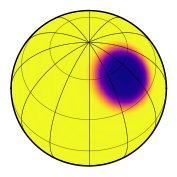

In [49]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.12458, radius=22.15108, lat=52.69509, lon=49.03136)
map.inc = 36.21473
map.show()

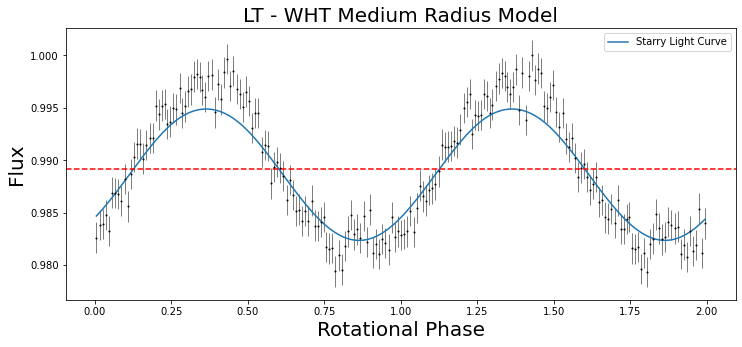

In [50]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('LT - WHT Medium Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [52]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

1.946899904739878

# WHT - Large Radius

In [53]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 88.75199
    lat = -30.72870
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 19.14318
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [54]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -707761.7456712507 -> 933.7729859719823


In [55]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.04568
lon          49.00563


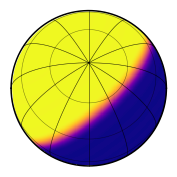

In [56]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.04568, radius=88.75199, lat=-30.72870, lon=49.00563)
map.inc = 19.14318
map.show()

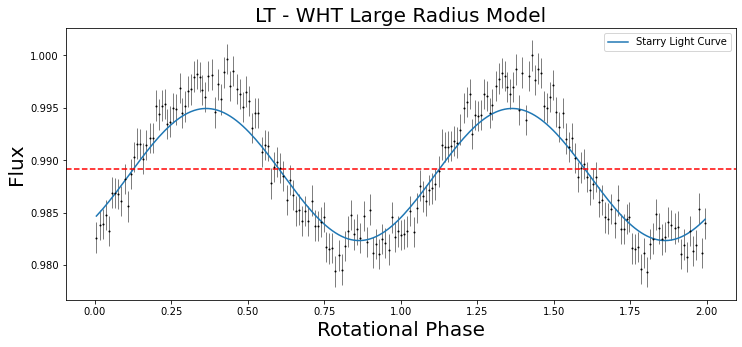

In [57]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('LT - WHT Large Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [59]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

1.9353486249095404

In [26]:
amplitude = (np.amax(newFlux) - np.amin(newFlux)) / 2
amplitude

0.006236893784212216

# Brinkworth 2004

In [20]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 40
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=30.0)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=45.0)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=1.4)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [21]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, contrast]


message: Optimization terminated successfully.
logp: -419163.21506976604 -> 976.1790829641535


In [23]:
keys = ["contrast", "lat", "lon", "inc"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.21708
lat          -5.94704
lon          49.22123
inc          11.91750


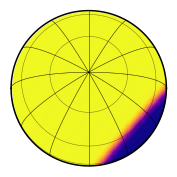

In [27]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.21708, radius=40, lat=-5.94704, lon=49.22123)
map.inc = 11.91750
map.show()

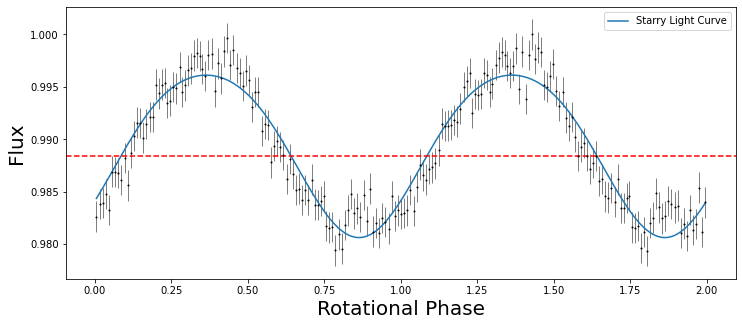

In [28]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.median(flux), color='r', linestyle='--');

In [26]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
chi_squared

281.62565264560055

In [29]:
amplitude = (np.amax(newFlux) - np.amin(newFlux)) / 2
amplitude

0.007748781333847321